# Convergence and Coverage

##### Keywords:  MCMC, metropolis, metropolis-hastings, step-size, autocorrelation

In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

## Practical thoughts on MCMC 

- despite the presence of MH to use asymmetric proposals, sometimes it might pay to just be lazy and accept additional computational time that might come with using a symmetric distribution
- the normal distribution is often a good choice

In [2]:
def metropolis(p, qdraw, stepsize, nsamp, xinit):
    samples=np.empty(nsamp)
    x_prev = xinit
    accepted = 0
    for i in range(nsamp):
        x_star = qdraw(x_prev, stepsize)
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdfratio = p_star/p_prev
        if np.random.uniform() < min(1, pdfratio):
            samples[i] = x_star
            x_prev = x_star
            accepted += 1
        else:#we always get a sample
            samples[i]= x_prev
            
    return samples, accepted

## The example from lecture

In [3]:
f = lambda x: 6*x*(1-x)

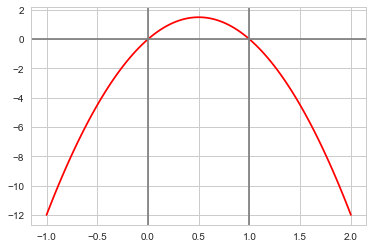

In [4]:
xxx= np.linspace(-1,2,100)
plt.plot(xxx, f(xxx), 'r') 
plt.axvline(0, 0,1, color="gray")
plt.axvline(1, 0,1, color="gray")
plt.axhline(0, 0,1, color="gray");

We wish to consider the support [0,1]. We could truncate our "distribution" beyond these. But it does not matter, even though we use a normal proposal whichcan propose negative and gretar-than-one $x$ values.

What happens if the proposal proposes a number outside of [0,1]? Notice then that our pdf is negative(ie it is not a pdf. (we could have defined it as 0 as well). Then in the metropolis acceptance formula, we are trying to check if a uniform is less than a negative or 0 number and we will not accept. This does however mean that we will need a longer set of samples than otherwise...

In [5]:
def prop(x, step):
    return np.random.normal(x, step)

### Reasonable Step Size

In [6]:
x0=np.random.uniform()
nsamps=100000
samps, acc = metropolis(f, prop, 0.6, nsamps, x0)

We decide to throw away 20% of our samples as burnin. 

In [7]:
burnin = int(nsamps*0.2)
burnin

20000

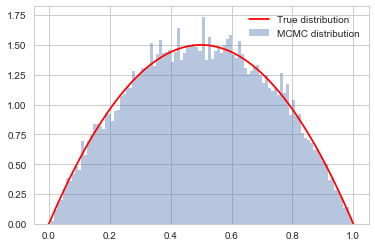

starting point was  0.3921063843029178 accepted 0.43437


In [9]:
# plot our sample histogram
plt.hist(samps[burnin:],bins=100, alpha=0.4, label=u'MCMC distribution', density=True) 
#plot the true function
xx= np.linspace(0,1,100)
plt.plot(xx, f(xx), 'r', label=u'True distribution') 
plt.legend()

plt.show()
print("starting point was ", x0, "accepted", acc/nsamps)

The last many samples look  very white-noise-y, which is good

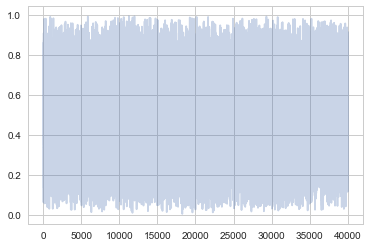

In [10]:
plt.plot(samps[-2*burnin:], alpha=0.3);

The first 3000 samples will show some correlations, especially at the beginning. There might be some trends as well as the chain takes its time finding out where the "action" is.

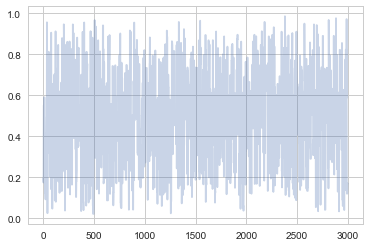

In [11]:
plt.plot(samps[:3000], alpha=0.3);

You will still see some small scale correlations. Thinning will  eliminate these. But thinning is NOT needed, it just makes things look better.

The idea behinf still doing thinning is a diagnostic though. If thinning does not remove autocorrelation, the autocorrelation is not due to the Markovian nature of things.

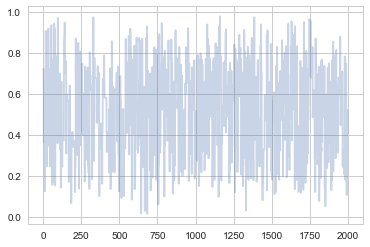

In [13]:
plt.plot(samps[burnin:burnin + burnin//10], alpha=0.3);

And lets just plot everything after burnin for comparison with small scales and large scales further down this document...

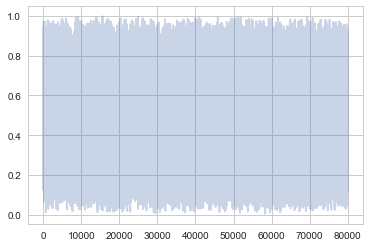

In [14]:
plt.plot(samps[burnin:], alpha=0.3);

Very white noisy. While one may (rightfully) worry that we are seeing no structure because we aint zoomed in, we'll compare this unzoomed plot at different scales further down.

We can check to see if the autocorrelation is decaying quickly...

In [15]:
def corrplot(trace, maxlags=50):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])

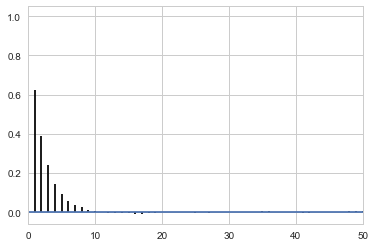

In [16]:
corrplot(samps[burnin:])

Thinning will  decrease the autocorrelation even further...

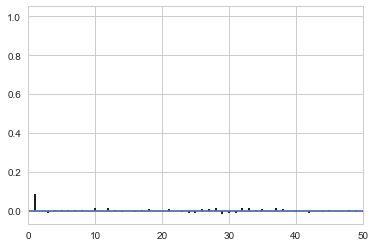

In [17]:
thin=5
sampsthin=samps[burnin::thin]
corrplot(sampsthin)

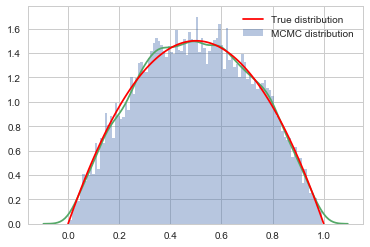

starting point was  0.3921063843029178 accepted 0.43437


In [18]:
# plot our sample histogram
plt.hist(sampsthin,bins=100, alpha=0.4, label=u'MCMC distribution', density=True) 
sns.kdeplot(sampsthin)
#plot the true function
xx= np.linspace(0,1,100)
plt.plot(xx, f(xx), 'r', label=u'True distribution') 
plt.legend()

plt.show()
print("starting point was ", x0, "accepted", acc/nsamps)

![](images/robotgoodmixing.png)

### Large Step Size

$\sigma$ controls the step size of our proposal. A large sigma corresponds to faster coverage, but we are going to miss out details. Because we propose a lot of moves that change probability a lot, we are going to have many "rejections".

In [19]:
samps2, acc2 = metropolis(f, prop, 10.0, nsamps, x0)
acc2/nsamps

0.02962

//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


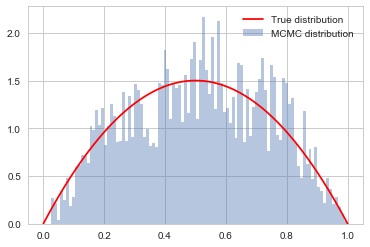

starting point was  0.3921063843029178 accepted 0.02962


In [20]:
# plot our sample histogram
plt.hist(samps2[burnin:],bins=100, alpha=0.4, label=u'MCMC distribution', normed=True) 
#plot the true function
xx= np.linspace(0,1,100)
plt.plot(xx, f(xx), 'r', label=u'True distribution') 
plt.legend()

plt.show()
print("starting point was ", x0, "accepted", acc2/nsamps)

![](images/largestep.png)

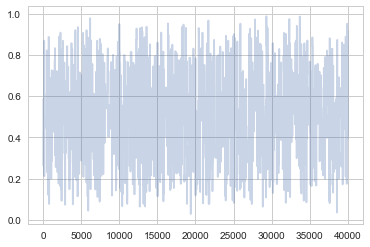

In [21]:
plt.plot(samps2[-2*burnin:], alpha=0.3);

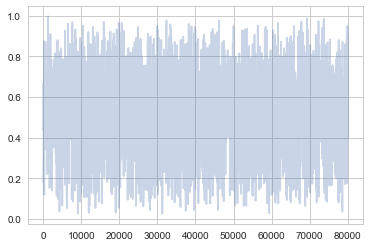

In [22]:
plt.plot(samps2[burnin:], alpha=0.3);

So you can see structure even when zoomed out...not good!

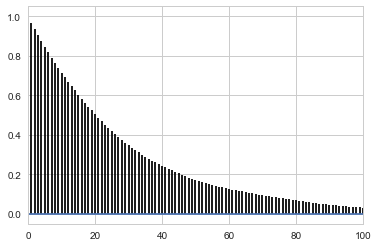

In [23]:
corrplot(samps2[burnin:], 100)

### Small step size

A small $\sigma$ corresponds to a smaller step size, and thus  our sampler takes longer. But because we make only small changes in probability, our acceptance ratio will be high!

In [24]:
samps3, acc3 = metropolis(f, prop, 0.01, nsamps, x0)
acc3/nsamps

0.98727

//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


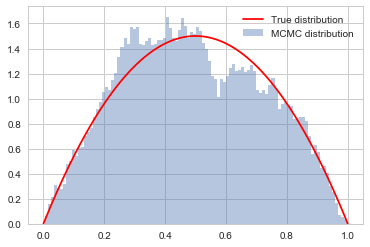

starting point was  0.3921063843029178 accepted 0.98727


In [25]:
# plot our sample histogram
plt.hist(samps3[burnin:],bins=100, alpha=0.4, label=u'MCMC distribution', normed=True) 
#plot the true function
xx= np.linspace(0,1,100)
plt.plot(xx, f(xx), 'r', label=u'True distribution') 
plt.legend()

plt.show()
print("starting point was ", x0, "accepted", acc3/nsamps)

![](images/smallstep.png)

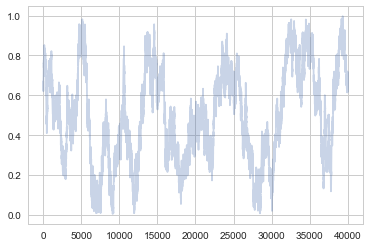

In [26]:
plt.plot(samps3[-2*burnin:], alpha=0.3);

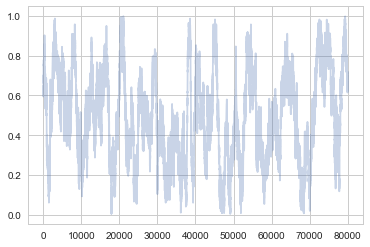

In [27]:
plt.plot(samps3[burnin:], alpha=0.3);

There's even  more structure here. Thats no way to be sampling! Sad!

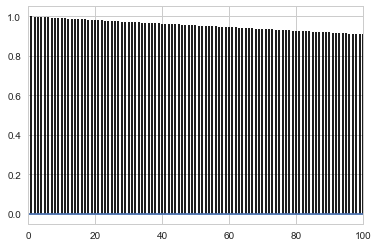

In [28]:
corrplot(samps3[burnin:], 100)

** A good rule of thumb is to shoot for about a 20%- 50% acceptance rate**

## Mixing and Convergence

*Mixing* is about how well we cover the relevant space.  *Convergence* is "are we there yet?" where by there we mean at the stationary distribution. Good mixing leads to faster convergence.

We do know that our sequence will converge as $n \to \infty$. But we dont want to be around, waiting for a very long time. And we dont know how many iterations it will take.

** We need to test for convergence **

This is just a lab. We will come to formal tests in a subsequent lecture, but currently let us look at some heuristics to build intution.

### Trace Plots

Trace plots are very useful for visual inspection. You should be able to see the burnin period, and then the chain produce something that looks like white noise.

**Inspecting the trace plot can show when we have not converged yet**. You will see large movements and regions of stasis where the autocorrelation is large. On the other hand, remember that without any formal tests, the traceplot cannot show for sure that we have converged either.

Some possibly useful visualizations:

- look at the whole plot
- divide into subsets of few 100s or few 1000s of samples and compare histograms/kdeplots
- start multiple different chains from random start points and compare the traceplots

### Autocorrelation

Autocorrelation can be a good diagnostic. After the burnin, the autocorrelation should decay within a few lags if we have reached ergodicity. There will likely still be some autocorrelation left. MCMC samples are samples from $p(x)$ and are guaranteed to be **act as IID**  due to the "ergodic" law of large numbers: time averages can be used as sample averages. But nearby samples are not *IID*, and you can help them along by shuffling the samples, and use thinning as a diagnostic to see if the autocorrelation becomes minimal. If it does, good, and you can use all your samples, but if not, you have probably not mixed well yet.